# FASHION MNIST Notebook

In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import xgboost
from sklearn.svm import LinearSVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt, matplotlib.image as mpimg


# pay attension:
### I will save time with few methods
- I will use a random sample (small random set) for save time while the process. at the end I will use the hole train set for the last model.
- Instead of using cross-validation, I will use other sample from the training data which will be a "test set" (it is not the final test set). I will do that because this is a big data and I just want to get a feeling what is the result of each model.

In [2]:
df_test = pd.read_csv("fashion-mnist_test.csv")
df = pd.read_csv("fashion-mnist_train.csv")
df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
X = df.drop(columns=['label'])
Y = df['label']

## normalize
X = X/255.

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state = 42)

In [4]:
# we have the same amount of instances in each class so we don't need to worry about imbalance
Y.value_counts(dropna=False)

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

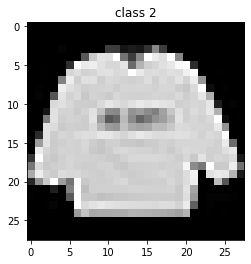

In [84]:
# this function plot image from the data
def image_plot(images_set, Y_labels, image_number):
    images = images_set.values
    images = images.reshape(-1, 28, 28)
    img = images[image_number]
    plt.imshow(img,cmap='gray')
    plt.title("class " + str(Y_labels.iloc[image_number]))
    
# for example:
image_plot(X, Y, 0)

### I will use a random sample for save time while the process. in the important points I will use the hole train set.

In [6]:
X_sample = X_train[:5000] #allready shaffeld
y_sample = y_train[:5000]

### PCA Dimensionality Reductioin
- from 784 features to 84
- 90% of the information remains

In [7]:
pca = PCA()
pca.fit(X_sample)
cumsum = np.cumsum(pca.explained_variance_ratio_)

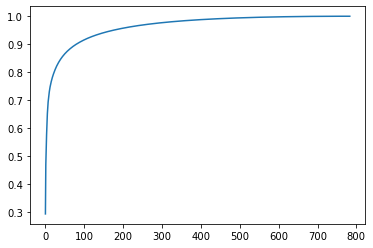

In [8]:
# the elbow is around 0.9 explaind varince, so this is a good point to use.
plt.plot(cumsum)

In [9]:
pca = PCA(n_components= 0.9)
pca.fit(X_train)
X_reduced = pca.transform(X_train)
X_sample_reduced = X_reduced[:5000]



In [10]:
print("from 784 features we have now only " + str(len(X_reduced[0])) + " features which remains 0.9 from the information (variance) of the original data!")

from 784 features we have now only 84 features which remains 0.9 from the information (variance) of the original data!


In [11]:
X_test_reduced = pca.transform(X_test)

In [12]:
X_recovered = pd.DataFrame(pca.inverse_transform(X_reduced))
# let's see the different before and after PCA of 0.9 withe less then 100 features:

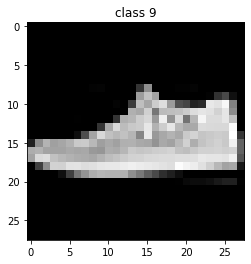

In [13]:
# before:
image_plot(X_train, y_train, 0)

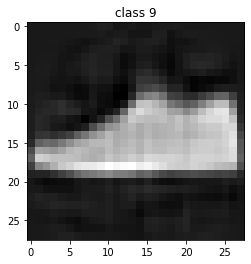

In [14]:
# after:
image_plot(X_recovered, y_train, 0)

In [15]:
# kmeans check:

kmeans = KMeans(n_clusters=50)
X_sample_dist = kmeans.fit_transform(X_sample_reduced)



In [16]:
mean_images = pd.DataFrame(kmeans.cluster_centers_)
mean_images.head()

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.989609,2.491467,0.642004,2.257071,2.989508,-1.788371,2.121288,0.310035,-0.572739,0.218146,...,0.001839,0.022197,0.042208,0.056659,0.062600,-0.079467,-0.063645,-0.053536,-0.152398,-0.023797
1,-0.939107,-3.118236,0.639077,0.959538,0.167242,1.176959,-0.519200,0.394215,0.206676,-0.023634,...,-0.037123,0.017594,-0.015550,0.046539,-0.030851,-0.022748,-0.008150,-0.010777,0.037871,-0.001398
2,7.413106,2.266117,1.551616,0.023590,0.323191,-1.153895,0.190019,-0.615508,-0.081446,-0.704456,...,0.015096,-0.013323,0.012044,-0.022838,0.007258,-0.010980,-0.014171,-0.012914,-0.002606,-0.002807
3,-0.242132,5.098739,-0.561324,-0.561611,1.690684,-1.058906,1.914295,1.962315,0.540407,0.803386,...,0.296987,-0.025544,-0.129284,-0.075496,-0.164891,-0.097904,-0.029550,0.037830,-0.051366,-0.078819
4,6.550931,-1.475613,-0.832504,1.153004,0.603329,4.306972,-0.533589,-0.158458,-0.229198,0.314160,...,0.032298,0.026484,-0.042149,-0.009507,0.075177,-0.061534,-0.072101,0.010853,-0.082542,0.051827


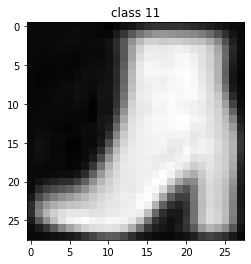

In [17]:
# we can check how is the mean of each cluster looks like, for example:
image_plot(pd.DataFrame(pca.inverse_transform(mean_images.values)), pd.Series(kmeans.labels_), 10)

### what are we going to do?
- I will train few models using the pca data.
- I will train few models using the distances from the kmeans.
- I instead of tuning each algorithem (using grid/random search etc), I will use default parameters and treat them as weak learners. then, I will use them all with a stacking (one of the ensemble method. I will also check the voting method, but I think stacking will perform better.

In [18]:
# this function will help me check running time for each algorithem

from datetime import datetime

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

## 1) train models using the PCA data:

#### XGBOOST:

In [19]:
xgb_clf = xgboost.XGBClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_clf.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_pred = xgb_clf.predict(X_test_reduced)
metrics.accuracy_score(y_pred, y_test)



C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 32.12 seconds.


0.8411666666666666

In [20]:
# I can use "early stopping for save a lot of time, the result is good as well.
# moreover, it will stop the model from overfitting.

xgb_clf_stop = xgboost.XGBClassifier(use_label_encoder=False)

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_clf_stop.fit(X_sample_reduced, y_sample, eval_set=[(X_test_reduced, y_test)], early_stopping_rounds=10)
timer(start_time) # timing ends here for "start_time" variable

y_pred = xgb_clf_stop.predict(X_test_reduced)
metrics.accuracy_score(y_pred, y_test)

[12:21:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:1.51239
[1]	validation_0-mlogloss:1.24300
[2]	validation_0-mlogloss:1.06905
[3]	validation_0-mlogloss:0.94510
[4]	validation_0-mlogloss:0.85204
[5]	validation_0-mlogloss:0.78117
[6]	validation_0-mlogloss:0.72581
[7]	validation_0-mlogloss:0.68211
[8]	validation_0-mlogloss:0.64595
[9]	validation_0-mlogloss:0.61843
[10]	validation_0-mlogloss:0.59380
[11]	validation_0-mlogloss:0.57610
[12]	validation_0-mlogloss:0.55964
[13]	validation_0-mlogloss:0.54587
[14]	validation_0-mlogloss:0.53512
[15]	validation_0-mlogloss:0.52505
[16]	validation_0-mlogloss:0.51713
[17]	validation_0-mlogloss:0.50964
[18]	validation_0-mlogloss:0.50448
[19]	validation_0-mlogloss:0.50108

0.8333333333333334

#### Logistic Regression:

In [21]:
log_reg = LogisticRegression(random_state=15, max_iter=10000)

start_time = timer(None) # timing starts from this point for "start_time" variable
log_reg.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = log_reg.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 2.4 seconds.


0.8346666666666667

#### linear svm:

In [22]:
LSVC = LinearSVC(random_state=6, C=1, tol=1e-5, loss="hinge")

start_time = timer(None) # timing starts from this point for "start_time" variable
LSVC.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = LSVC.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 0.86 seconds.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8326666666666667

#### polynomial svm, degree of 2:

In [24]:
polynomial_svm_2 = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2)),
    ("svm_clf", LinearSVC(random_state=6, C=10, tol=1e-5, loss="hinge"))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
polynomial_svm_2.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = polynomial_svm_2.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



 Time taken: 0 hours 1 minutes and 1.55 seconds.


0.8386666666666667

#### Random Forest:

In [25]:
RFC = RandomForestClassifier()

start_time = timer(None) # timing starts from this point for "start_time" variable
RFC.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = RFC.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 4.65 seconds.


0.8285

#### KNN

In [38]:
knn = KNeighborsClassifier(n_neighbors=50)

start_time = timer(None) # timing starts from this point for "start_time" variable
knn.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = knn.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 0.12 seconds.


0.7893333333333333

#### Bagging models

In [30]:
bag_log_reg = BaggingClassifier(
    LogisticRegression(random_state=15, max_iter=10000), bootstrap=True)

start_time = timer(None) # timing starts from this point for "start_time" variable
bag_log_reg.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = bag_log_reg.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 23.55 seconds.


0.8371666666666666

In [41]:
bag_svm = BaggingClassifier(
    LinearSVC(random_state=6, C=1, tol=1e-3, loss="hinge", max_iter=300000), bootstrap=True)

start_time = timer(None) # timing starts from this point for "start_time" variable
bag_svm.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = bag_svm.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 53.32 seconds.


0.8305

#### Adaboost model:

In [39]:
ada_RFC = AdaBoostClassifier(RandomForestClassifier(), n_estimators=200, learning_rate=0.1)

start_time = timer(None) # timing starts from this point for "start_time" variable
ada_RFC.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = ada_RFC.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)


 Time taken: 0 hours 0 minutes and 4.34 seconds.


0.833


## 2) train models using Kmeans:

#### XGB

In [44]:
xgb_kmeans = Pipeline([
    ("kmeans", KMeans(n_clusters=50)), 
    ("xgboost", xgboost.XGBClassifier(use_label_encoder=False))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
xgb_kmeans.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

xgb_kmeans.score(X_test_reduced, y_test)

[12:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 Time taken: 0 hours 0 minutes and 22.95 seconds.


0.7848333333333334

#### Logistic regression

In [48]:
log_reg_pipline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)), 
    ("log-reg", LogisticRegression(max_iter=100000))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
log_reg_pipline.fit(X=X_sample_reduced, y=y_sample)
timer(start_time) # timing ends here for "start_time" variable

log_reg_pipline.score(X_test_reduced, y_test)


 Time taken: 0 hours 0 minutes and 50.24 seconds.


0.8133333333333334

#### Random Forest

In [49]:
RFR_kmeans_pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)), 
    ("random_forest", RandomForestClassifier())
])

start_time = timer(None) # timing starts from this point for "start_time" variable
RFR_kmeans_pipeline.fit(X=X_sample_reduced, y=y_sample)
timer(start_time) # timing ends here for "start_time" variable

RFR_kmeans_pipeline.score(X_test_reduced, y_test)


 Time taken: 0 hours 0 minutes and 6.11 seconds.


0.7665

#### SVM

In [51]:
svm_kmeans_pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)), 
    ("svm", LinearSVC(random_state=6, C=1, tol=1e-5, loss="hinge", max_iter=300000))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
svm_kmeans_pipeline.fit(X=X_sample_reduced, y=y_sample)
timer(start_time) # timing ends here for "start_time" variable

svm_kmeans_pipeline.score(X_test_reduced, y_test)


 Time taken: 0 hours 0 minutes and 56.18 seconds.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.7986666666666666

#### KNN

In [52]:
knn_kmeans_pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)), 
    ("knn", KNeighborsClassifier(n_neighbors=50))
])

start_time = timer(None) # timing starts from this point for "start_time" variable
knn_kmeans_pipeline.fit(X=X_sample_reduced, y=y_sample)
timer(start_time) # timing ends here for "start_time" variable

knn_kmeans_pipeline.score(X_test_reduced, y_test)


 Time taken: 0 hours 0 minutes and 2.63 seconds.


0.7313333333333333

# I will use only PCA data from now becuse kmeans has lower scores

#### Voting model using severl comination of estimators:

In [55]:
from sklearn.ensemble import VotingClassifier
voting_pca = VotingClassifier(estimators=[('xgb', xgb_clf), ('log_reg', log_reg),
                                          ('linear svm', LSVC), ('poly svm', polynomial_svm_2),
                                          ('random forest', RFC), ('knn', knn),
                                          ('bagging log reg', bag_log_reg), ('bagging svm', bag_svm),
                                          ('adaboost random forest', ada_RFC)])
voting_pca.fit(X_sample_reduced, y_sample)

y_predict = voting_pca.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8515

In [56]:
from sklearn.ensemble import VotingClassifier
voting_kmeans = VotingClassifier(estimators=[('xgb kmeans', xgb_kmeans), ('log_reg_pipline', log_reg_pipline),
                                          ('RFR_kmeans_pipeline', RFR_kmeans_pipeline), ('svm_kmeans_pipeline', svm_kmeans_pipeline),
                                          ('knn_kmeans_pipeline', knn_kmeans_pipeline)
                                         ])
voting_pca.fit(X_sample_reduced, y_sample)

y_predict = voting_pca.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:02:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8523333333333334

In [57]:
from sklearn.ensemble import VotingClassifier
voting_pca = VotingClassifier(estimators=[('xgb', xgb_clf), ('log_reg', log_reg),
                                          ('linear svm', LSVC), ('poly svm', polynomial_svm_2),
                                          ('random forest', RFC), ('knn', knn),
                                          ('bagging log reg', bag_log_reg), ('bagging svm', bag_svm),
                                          ('adaboost random forest', ada_RFC), ('xgb kmeans', xgb_kmeans),
                                          ('log_reg_pipline', log_reg_pipline),
                                          ('RFR_kmeans_pipeline', RFR_kmeans_pipeline), 
                                          ('svm_kmeans_pipeline', svm_kmeans_pipeline),
                                          ('knn_kmeans_pipeline', knn_kmeans_pipeline)])
voting_pca.fit(X_sample_reduced, y_sample)

y_predict = voting_pca.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:05:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[13:08:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


0.8401666666666666

#### Stacking models:

In [61]:
from sklearn.ensemble import StackingClassifier
estimators = [('xgb', xgb_clf), ('log_reg', log_reg),
              ('linear svm', LSVC), ('poly svm', polynomial_svm_2),
              ('random forest', RFC), ('knn', knn),
              ('bagging log reg', bag_log_reg), ('bagging svm', bag_svm),
              ('adaboost random forest', ada_RFC), ('xgb kmeans', xgb_kmeans),
              ('log_reg_pipline', log_reg_pipline),
              ('RFR_kmeans_pipeline', RFR_kmeans_pipeline), 
              ('svm_kmeans_pipeline', svm_kmeans_pipeline),
              ('knn_kmeans_pipeline', knn_kmeans_pipeline)]
adaboost_stacking = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression(max_iter=100000))

adaboost_stacking.fit(X_sample_reduced, y_sample)

y_predict = adaboost_stacking.predict(X_test_reduced)
metrics.accuracy_score(y_predict, y_test)

C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[13:57:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:59:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

[14:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:11:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

0.8581666666666666

## FINAL MODEL
- I will use all the models which have an accuracy above 0.8.
- most of the kmeans models are not good enougth, we can see that also in the voting classifier (adding them reduce the result). So, I removed them from the final model.
- I will use 10,000 instances from the train data because it takes a lot of time. I believe it will not change a lot.

In [65]:
X_test = df_test.drop(columns=['label'])
Y_test = df_test['label']

## normalize the test
X_test = X_test/255.

pca = PCA(n_components= 0.9)
pca.fit(X) # the train set, allready normalized
X_reduced = pca.transform(X_train) #X_train is the shuffled X
X_sample_reduced = X_reduced[:10000]
y_sample = y_train[:10000] #allready shaffeld
X_test_pca = pca.transform(X_test)

In [67]:
from sklearn.ensemble import StackingClassifier
estimators = [('xgb', xgboost.XGBClassifier(use_label_encoder=False)), ('log_reg', log_reg),
              ('linear svm', LSVC), ('poly svm', polynomial_svm_2),
              ('random forest', RFC), ('bagging log reg', bag_log_reg),
              ('bagging svm', bag_svm), ('adaboost random forest', ada_RFC)]
adaboost_stacking = StackingClassifier(estimators=estimators, final_estimator= LogisticRegression(max_iter=200000))

start_time = timer(None) # timing starts from this point for "start_time" variable
adaboost_stacking.fit(X_sample_reduced, y_sample)
timer(start_time) # timing ends here for "start_time" variable

y_predict = adaboost_stacking.predict(X_test_pca)
metrics.accuracy_score(y_predict, Y_test)

[16:09:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[16:15:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:16:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\idank\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations


 Time taken: 0 hours 31 minutes and 8.74 seconds.


0.869

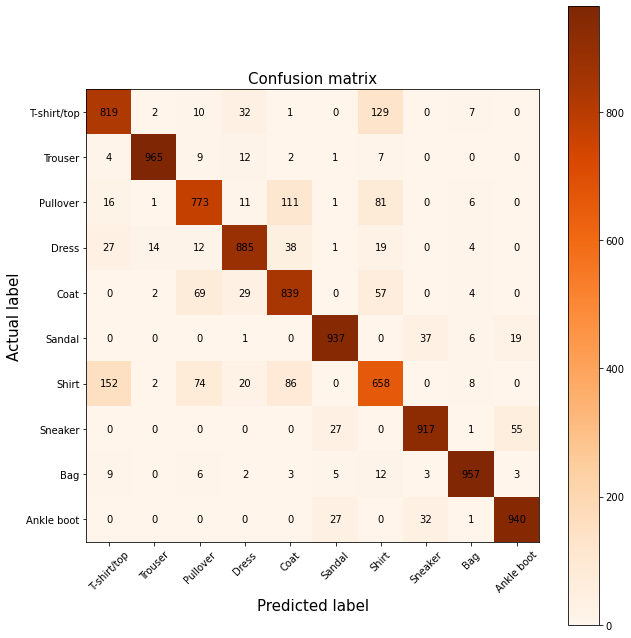

In [82]:
y_pred_series = pd.Series(y_predict, index = Y_test.index)

cm = confusion_matrix(Y_test, y_pred_series)
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Oranges')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 
                        'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'], rotation=45, size = 10)
plt.yticks(tick_marks, ['T-shirt/top', 'Trouser', 'Pullover', 
                        'Dress', 'Coat', 'Sandal', 'Shirt', 
                        'Sneaker', 'Bag', 'Ankle boot'], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

# Final model accouracy = 0.87

#### what did I do?
- normalize the data.
- PCA to lower the dimensionality. (784 to 84, 90% variance).
- try to use clustering with kmeans, but it was not good as expected.
- training few models.
- using ensemble methods - boosting, bagging, pasting and voting.

#### what can I do more?
- check for each model what scaling perform better
- tuning each model with random/grid search
- use other methods to lower the dimensionality
note: all those options took a lot time so I didn't do that.